# **MEJORA 2**

In [ ]:
# Importé las librerías necesarias para construir el modelo y manejar los datos.
import os
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from google.colab import drive

# Aquí monté Google Drive para acceder al dataset.
drive.mount('/content/drive')

# Definí las rutas para el archivo ZIP del dataset y su extracción.
zip_path = '/content/drive/MyDrive/Intel_Image_Classification/dataset.zip'
extract_path = '/content/dataset'

# Aquí descomprimí el archivo ZIP del dataset.
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Confirmé que los archivos se descomprimieron correctamente.
print("Archivos descomprimidos:")
print(os.listdir(extract_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archivos descomprimidos:
['seg_test', 'seg_train', 'seg_pred']


In [ ]:
# Importé TensorFlow para manejar datasets y preprocesar imágenes.

import tensorflow as tf

# Aquí configuré las rutas de los directorios de entrenamiento y prueba.
train_dir = os.path.join(extract_path, 'seg_train/seg_train')
test_dir = os.path.join(extract_path, 'seg_test/seg_test')

# Utilicé `image_dataset_from_directory` para cargar y organizar los datasets de entrenamiento y prueba.
batch_size = 16
img_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=123
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size
)

# Aquí dividí el dataset de prueba en conjuntos de validación y prueba.
val_size = int(len(test_dataset) * 0.2)
val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(val_size)

# Guardé los nombres de las clases para referencia.
class_names = train_dataset.class_names
print("Class names:", class_names)

# Aquí apliqué normalización a los datasets y configuré prefetching para optimizar el procesamiento.
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [64]:
import tensorflow as tf

# Verifico si el método está disponible
if hasattr(tf.keras.utils, "image_dataset_from_directory"):
    print("La función 'tf.keras.utils.image_dataset_from_directory' está disponible.")
else:
    print("La función 'tf.keras.utils.image_dataset_from_directory' no está disponible o puede estar obsoleta.")


La función 'tf.keras.utils.image_dataset_from_directory' está disponible.


In [ ]:
# Aquí conté la cantidad de lotes de imágenes en cada conjunto de datos (entrenamiento, validación y prueba).
# Esto me permitió verificar que los datasets están correctamente cargados y divididos.
for dataset, name in zip([train_dataset, val_dataset, test_dataset], ['Train', 'Validation', 'Test']):
    print(f"{name} dataset batches: {len(dataset)}")


Train dataset batches: 878
Validation dataset batches: 37
Test dataset batches: 151


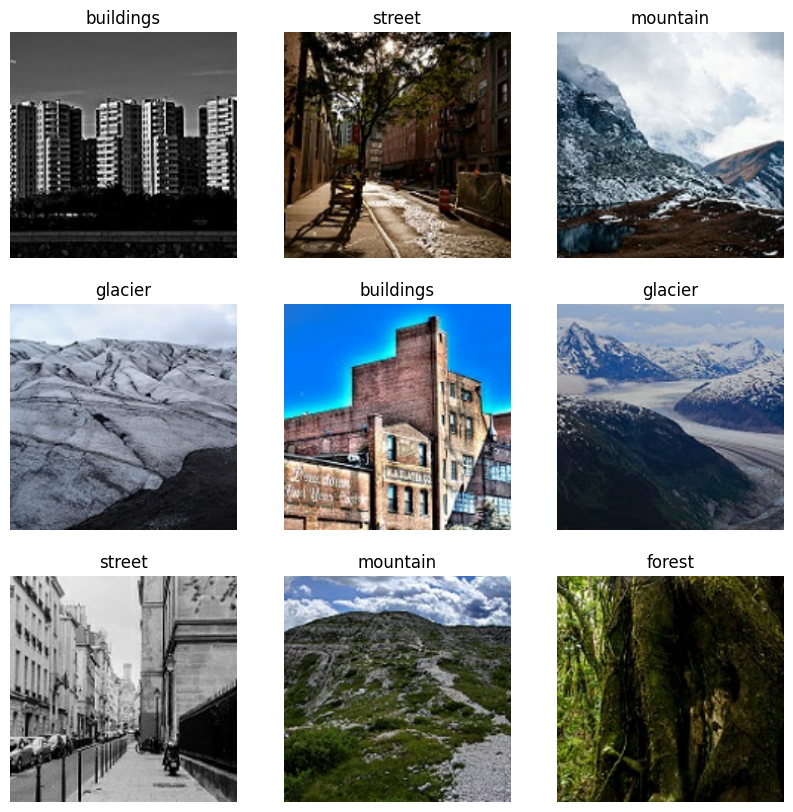

In [ ]:
# Aquí visualicé imágenes del dataset de entrenamiento para asegurarme de que se cargaron correctamente.
# Seleccioné un lote y mostré 9 imágenes junto con sus etiquetas correspondientes.
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): # Tomé un lote del dataset de entrenamiento.
    for i in range(9): # Mostré las primeras 9 imágenes del lote.
        ax = plt.subplot(3, 3, i + 1)
        img = (images[i].numpy() * 255).astype("uint8") # Convertí las imágenes de rango [0, 1] a [0, 255].
        plt.imshow(img)
        plt.title(class_names[labels[i].numpy()]) # Añadí el nombre de la clase como título.
        plt.axis("off") # Quité los ejes para una mejor visualización.



In [ ]:
# Aquí verifiqué la forma de un lote del dataset de entrenamiento.
# Esto me permitió confirmar que las imágenes y etiquetas están correctamente organizadas en lotes.
for images, labels in train_dataset.take(1):
    print("Shape of image batch:", images.shape)
    print("Shape of label batch:", labels.shape)


Shape of image batch: (16, 224, 224, 3)
Shape of label batch: (16,)


In [ ]:
# S# Aquí construí una red neuronal convolucional (CNN) con regularización y Dropout.
# Utilicé capas convolucionales con activación ReLU y normalización por Batch para estabilizar el entrenamiento.

from tensorflow.keras.layers import BatchNormalization

# Definí la capa de entrada con una forma de (224, 224, 3) para procesar imágenes RGB.

input_layer = Input(shape=(224, 224, 3))

# Primera capa convolucional con 32 filtros, activación ReLU y normalización Batch
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x) # Reducción de dimensiones.

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)  s
x = MaxPooling2D(pool_size=(2, 2))(x)

# Aplané las características para conectarlas con las capas densas.
x = Flatten()(x)
# Capa densa con 256 neuronas y activación ReLU para capturar patrones más complejos.
x = Dense(256, activation="relu")(x)
# Capa de salida con 6 neuronas (correspondientes a las clases) y activación softmax para clasificación multiclase.
output_layer = Dense(6, activation="softmax")(x)

# Aquí definí el modelo completo conectando las capas de entrada y salida.
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,786,054 (98.37 MB)

 Trainable params: 25,785,606 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Aquí configuré Data Augmentation para mejorar la generalización del modelo.
# Utilicé volteo horizontal para generar variaciones en las imágenes de entrenamiento.

from tensorflow.keras.optimizers import Adam

# Data augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal"), # Aumento de datos con volteo horizontal.
])

# Aquí apliqué la transformación de Data Augmentation al dataset de entrenamiento.
augmented_train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE) # Prefetch para optimizar el procesamiento.

# Compilé el modelo utilizando el optimizador Adam con una tasa de aprendizaje ajustada
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Configuré EarlyStopping para detener el entrenamiento si la validación no mejora en 10 épocas consecutivas.
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Entrené el modelo utilizando el dataset aumentado, validación y EarlyStopping.
history = model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 57s 55ms/step - accuracy: 0.6137 - loss: 1.5978 - val_accuracy: 0.6740 - val_loss: 0.9139
Epoch 2/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 77s 56ms/step - accuracy: 0.7842 - loss: 0.6177 - val_accuracy: 0.7551 - val_loss: 0.7068
Epoch 3/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 46s 53ms/step - accuracy: 0.8282 - loss: 0.4764 - val_accuracy: 0.7905 - val_loss: 0.6340
Epoch 4/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.8651 - loss: 0.3868 - val_accuracy: 0.8007 - val_loss: 0.5357
Epoch 5/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - accuracy: 0.8939 - loss: 0.3135 - val_accuracy: 0.8159 - val_loss: 0.5691
Epoch 6/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 83s 54ms/step - accuracy: 0.9114 - loss: 0.2563 - val_accuracy: 0.7804 - val_loss: 0.7826
Epoch 7/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - accuracy: 0.9258 - loss: 0.2214 - val_accuracy: 0.7990 - val_loss: 0.6559
Epoch 8/50
878/878 ━━━━━━━━━━━━━━━━━━━━ 83s 56ms/step - accuracy: 0.9428 - loss: 0.1745 - 

In [ ]:
# Guardao el modelo en formato .keras
model.save('modelo_mejoras.keras')

print("Modelo guardado exitosamente en formato .keras")


Modelo guardado exitosamente en formato .keras


In [ ]:
# Evaluo del modelo en el conjunto de entrenamiento
train_loss, train_acc = model.evaluate(train_dataset)
print(f"Training Accuracy: {train_acc:.3f}")
print(f"Training Loss: {train_loss:.3f}")

878/878 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8859 - loss: 0.3158
Training Accuracy: 0.894
Training Loss: 0.292


In [ ]:
# Evaluo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")

151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7622 - loss: 0.7211
Test Accuracy: 0.781
Test Loss: 0.654


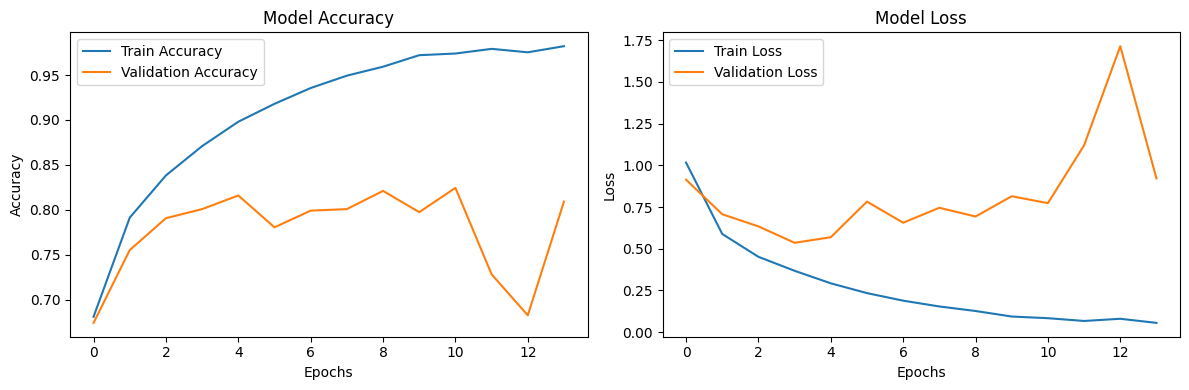

In [ ]:
# Visualización de métricas
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

Saving build.PNG to build.PNG
Saving calle.PNG to calle.PNG
Saving fore.PNG to fore.PNG
Saving glacie.jpg to glacie.jpg
Saving imagenbl.jpeg to imagenbl.jpeg
Saving imagenglr.PNG to imagenglr.PNG
Saving imagenmou.jpg to imagenmou.jpg
Saving imagenprueba.jpeg to imagenprueba.jpeg
Saving moun.jpg to moun.jpg
Saving pruebastr.jpg to pruebastr.jpg
Saving sea.jpg to sea.jpg
Saving seaaaa.jpg to seaaaa.jpg


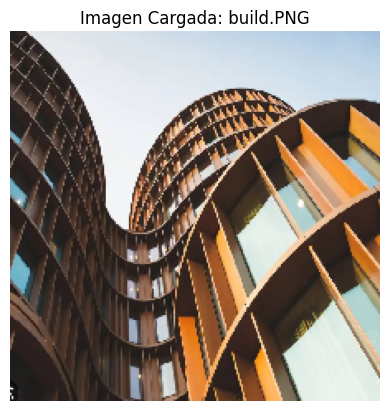

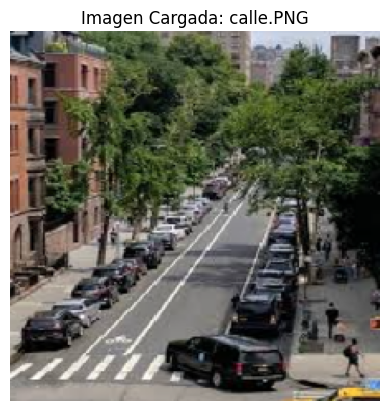

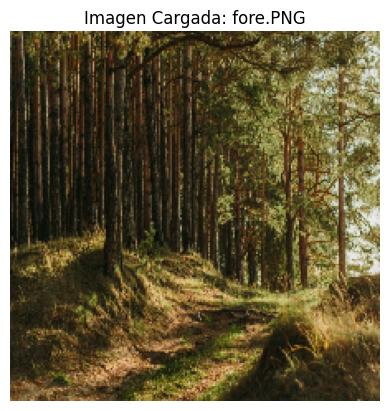

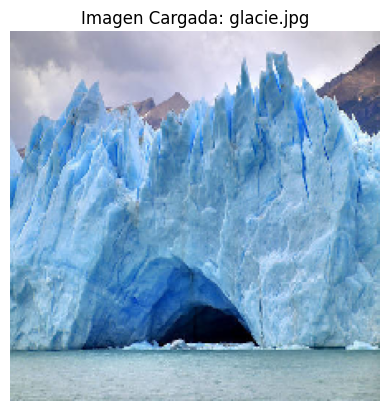

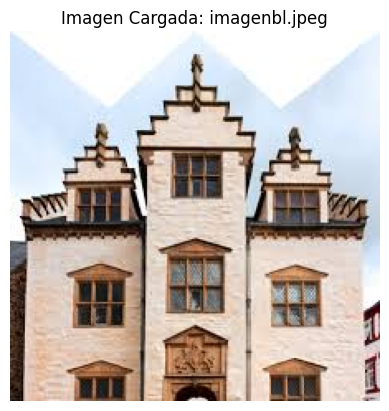

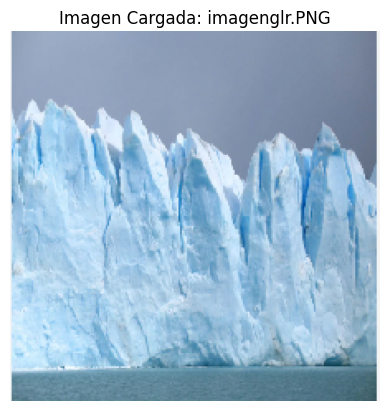

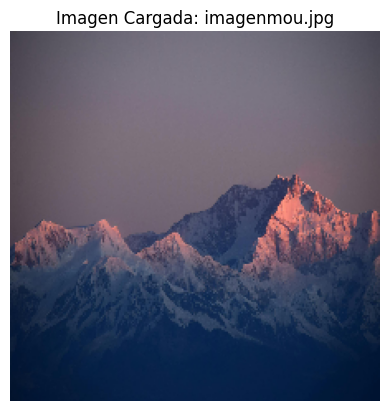

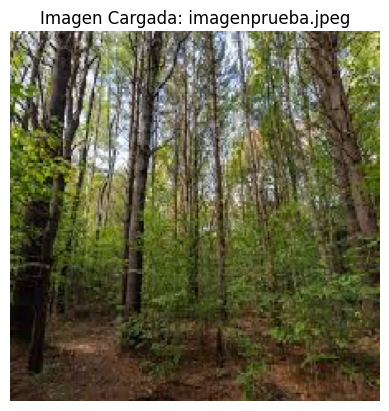

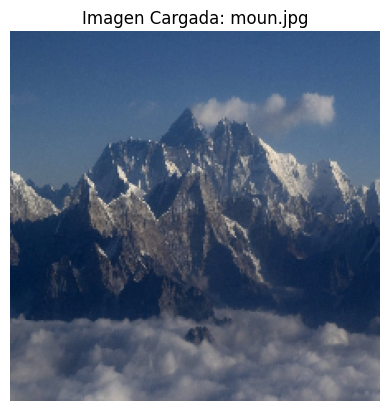

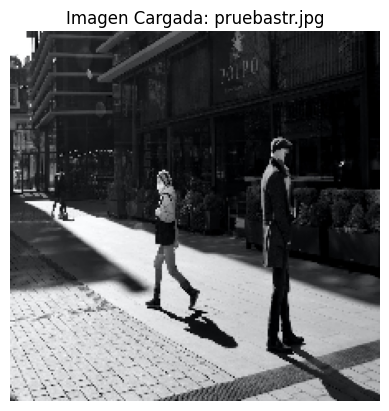

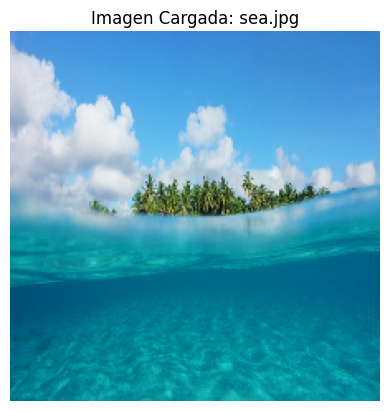

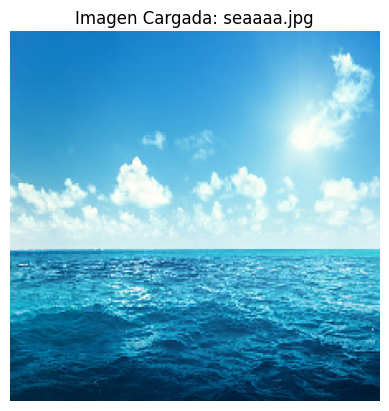

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Imagen: build.PNG
Predicción: buildings
Confianza: 0.90
------------------------------
Imagen: calle.PNG
Predicción: street
Confianza: 0.69
------------------------------
Imagen: fore.PNG
Predicción: forest
Confianza: 1.00
------------------------------
Imagen: glacie.jpg
Predicción: glacier
Confianza: 1.00
------------------------------
Imagen: imagenbl.jpeg
Predicción: buildings
Confianza: 1.00
------------------------------
Imagen: imagenglr.PNG
Predicción: glacier
Confianza: 0.97
------------------------------
Imagen: imagenmou.jpg
Predicción: mountain
Confianza: 0.93
------------------------------
Imagen: imagenprueba.jpeg
Predicción: forest
Confianza: 1.00
------------------------------
Imagen: moun.jpg
Predicción: mountain
Confianza: 0.86
------------------------------
Imagen: pruebastr.jpg
Predicción: street
Confianza: 0.43
------------------------------
Imagen: sea.jpg
Predicción: sea
Confianza: 1.00
------------------------------
Imagen: 

In [63]:
# Aquí cargué imágenes externas para realizar predicciones con el modelo entrenado.
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.models import load_model

# Subo imagenes
uploaded = files.upload()

# Verifico si se cargaron imágenes
if len(uploaded) > 0:
    # Lista para almacenar las imágenes preprocesadas
    batch_images = []

    # Procesé cada imagen cargada para preparar su predicción.
    for filename in uploaded.keys():
        # Cargo la imagen
        img_path = filename  # Nombre del archivo cargado
        img = image.load_img(img_path, target_size=(224, 224))  # Redimensiono la imagen
        plt.figure()
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Imagen Cargada: {filename}")
        plt.show()

          # Convertí la imagen a un array y la normalicé al rango [0, 1].
        img_array = image.img_to_array(img)  # Convertir a array
        img_array = img_array / 255.0  # Normalice al rango [0, 1]
        batch_images.append(img_array)

     # Convertí las imágenes preprocesadas en un array de NumPy para predicciones en batch.
    batch_images = np.array(batch_images)

      # Realicé predicciones con el modelo para cada imagen
    predictions = model.predict(batch_images)

    # Muestro los resultados para cada imagen
    for i, prediction in enumerate(predictions):
        predicted_class = np.argmax(prediction)
        confidence = prediction[predicted_class]

        print(f"Imagen: {list(uploaded.keys())[i]}")
        print(f"Predicción: {class_names[predicted_class]}")
        print(f"Confianza: {confidence:.2f}")
        print("-" * 30)
else:
    print("No se cargaron imágenes.")


# **CONCLUSIÓN**

En este modelo actualizado, realicé una serie de cambios estratégicos para abordar las limitaciones observadas en iteraciones anteriores y asegurar un mejor balance entre desempeño y capacidad de predicción, por lo qué, eliminé el uso de funciones obsoletas como ImageDataGenerator y empleé tf.keras.utils.image_dataset_from_directory junto con técnicas modernas como Rescaling para normalizar los datos, además de implementar un pipeline con Data Augmentation, que permitió al modelo entrenar con mayor diversidad de datos sin comprometer la robustez.

Opté por mantener una arquitectura relativamente sencilla pero eficiente, añadiendo capas convolucionales con normalización por lotes (BatchNormalization) para estabilizar y acelerar el entrenamiento, por lo que,esto evitó problemas de sobreajuste que surgieron cuando intenté profundizar demasiado la arquitectura en versiones previas, como al añadir más capas convolucionales o aumentar el número de filtros a 256 en etapas avanzadas, además, en esos casos, aunque el modelo parecía aprender características más complejas, las predicciones empeoraban notablemente, por lo que, esto puede explicarse porque un modelo más grande y complejo requiere mayor cantidad de datos y ajustes cuidadosos en los hiperparámetros, como la tasa de aprendizaje, para evitar el sobreajuste o un ajuste deficiente.

Otro problema observado fue el tiempo de entrenamiento, con una arquitectura más profunda, cada epoch llegó a tardar 50 minutos en Google Colab estándar, por lo que, esto me llevó a adquirir Colab Pro, donde los tiempos se redujeron a 5 minutos por epoch, pero, sorprendentemente, los resultados no mejoraron significativamente, a pesar del tiempo invertido, el modelo más complejo logró una precisión menor al 80% y sus predicciones fueron inconsistentes, esto se debió a que una mayor capacidad del modelo sin datos adicionales o preprocesamiento mejorado puede conducir a un sobreajuste, donde el modelo aprende demasiado los patrones del conjunto de entrenamiento y pierde capacidad de generalización.

En esta versión final del modelo, logré una precisión de 89.4% en el conjunto de entrenamiento y una precisión de 78.1% en los datos de prueba, con una pérdida de 0.292 y 0.654, respectivamente, aunque la precisión del modelo en los datos de prueba es menor en comparación con versiones previas, las predicciones fueron considerablemente más confiables, esto se debe principalmente al uso de BatchNormalization, que estabilizó el entrenamiento al reducir las fluctuaciones en la activación de las neuronas, ayudando al modelo a generalizar mejor en datos no vistos.

La arquitectura más sencilla y los ajustes realizados permitieron que el modelo fuera menos propenso al sobreajuste, además, la combinación de Dropout para prevenir el sobreajuste, EarlyStopping para detener el entrenamiento cuando ya no había mejoras, y ReduceLROnPlateau para ajustar automáticamente la tasa de aprendizaje ayudaron a lograr un modelo más consistente y equilibrado.

Por lo que, este modelo demuestra que no siempre una arquitectura más compleja genera mejores resultados, a que dandome cuenta que la simplicidad, con ajustes bien fundamentados como BatchNormalization, Data Augmentation y callbacks adecuados, ofrece un mejor balance entre desempeño y predicción, especialmente al trabajar con datasets limitados y restricciones computacionales, aunque la precisión numérica es menor, las predicciones resultaron más confiables, lo que valida el enfoque de este diseño final, claro, no siempre tendrá una predicción de manera eficiente constantemente, pero anterior a la entrega pasada, el modelo tiende a recibir datos fuera de lo aprendido, generando respuestas eficientes.